<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h1> 1.1 Description </h1>

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


> Credits: Kaggle

__ Problem Statement __

Identify which questions asked on Quora are duplicates of questions that have already been asked.
This could be useful to instantly provide answers to questions that have already been answered.
We are tasked with predicting whether a pair of questions are duplicates or not.

<h1> Business/Real world objectives and constraints </h1>

1. Cost of miscassifiaction can be high .
2. No strict layency concerns .
3. Interpretability is partial important .

<h1> 2. Machine learning problem </h1>

<h2> 2.1. Data </h2>

<h3> 2.1.1 Data Overview </h3>

- Data will be in a file train.csv .
- train.csv contins 5 columns : qid1 , qid2 , question1 , question2 , is_duplicate
- Size of train.csv is 60Mb .
- Total numbers of rows in train.csv is 404,290

<h2> 2.2 Mapping Real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

It is binary classification problem , for a given pair of questions we need to predict is_duplicate or not .

<h3> 2.2.2 Performance Matics </h3>

Metrics:
* Log_loss
* Cofusion Matrix

<h2> 2.3. Train Test Split Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1> 3. Exploratory Data Analysis </h1>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sn 
import numpy as np 
import nltk 
import re
import os 
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
import distance

<h2> 3.1. Reading Data and Basic Stats </h2>

In [11]:
df= pd.read_csv('train.csv')

df=df.head(150000)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            150000 non-null  int64 
 1   qid1          150000 non-null  int64 
 2   qid2          150000 non-null  int64 
 3   question1     150000 non-null  object
 4   question2     149999 non-null  object
 5   is_duplicate  150000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 6.9+ MB


We are given minimal numbers of data fields here , consisting of  :

* id: Looks like simple row_id 
* qid{1,2}: The unique id of each question in the pair 
* question{1,2} : The Actual text contents of question .
* is_duplicate : The label that we trying to preict - whether the two questions are duplicate of each other .

<h2> 3.2. Distribution of Data among Output clasees </h2>

<AxesSubplot:xlabel='is_duplicate'>

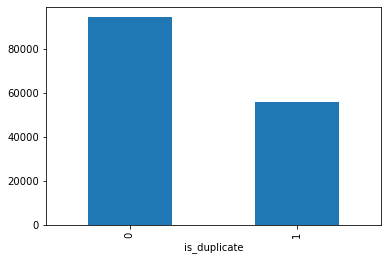

In [13]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [14]:
print('Total number of question pair in D_train: ', len(df))

Total number of question pair in D_train:  150000


In [15]:
print('Total no of duplicate quetion : {}%'.format(round(df['is_duplicate'].mean()*100, 2 ) ) )

print('Total no of non duplicate quetion : {} %'.format(100 - round(df['is_duplicate'].mean()*100, 2 ) ))

Total no of duplicate quetion : 37.24%
Total no of non duplicate quetion : 62.76 %


<h3> 3.2.2 No of unique  questions </h3>

In [16]:
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))
q_more_than_1time =  np.sum(qids.value_counts() >1)

print('Total no of unique question :', unique_qs)

print('\nNO of unique question that appear more than 1 time : {}  ({})% '.format(q_more_than_1time , q_more_than_1time/unique_qs*100))


print('\nQuestion that appear most time :', max(qids.value_counts()))

#q_vals = qids.value_counts()
#q_vals= q_vals.values 

Total no of unique question : 236162

NO of unique question that appear more than 1 time : 33088  (14.010721453917228)% 

Question that appear most time : 52


C:\Users\welcome\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


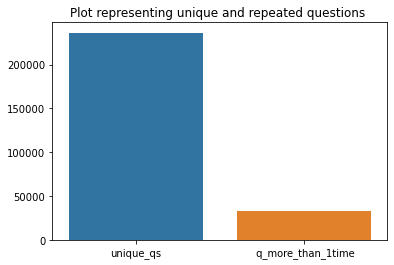

In [17]:
x=['unique_qs' ,' q_more_than_1time']
y=[unique_qs , q_more_than_1time]

sn.barplot(x,y)
plt.title('Plot representing unique and repeated questions ')
plt.show()

<h3> 3.2.3. Checking for duplicates pairs : </h3>

In [21]:
pair_duplicates =df[['qid1' ,'qid2', 'is_duplicate']].groupby(['qid1' ,'qid2']).count()


print('no of duplicate pairs :' ,pair_duplicates.shape[0]-df.shape[0])

no of duplicate pairs : 0


<h3> 3.2.4. Number of occurances of each question </h3>

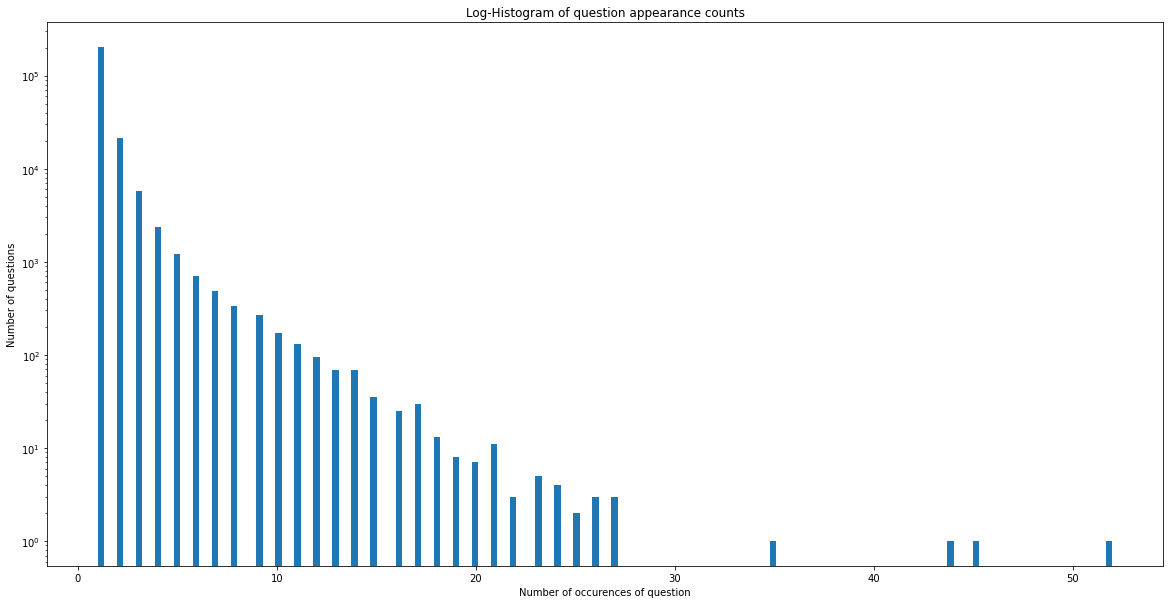

In [10]:
plt.figure(figsize=(20,10))

plt.hist(qids.value_counts(), bins=160)


plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

plt.show()

<h3> 3.2.5 Checking for null values </h3>

In [23]:
print(df[df.isnull().any(1)])

            id    qid1    qid2                       question1 question2  \
105780  105780  174363  174364  How can I develop android app?       NaN   

        is_duplicate  
105780             0  


* There are 3 rows which consists of null values .

In [24]:
# filling the null values with ''
df=df.fillna(' ')

print(df[df.isnull().any(1)])

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2> 3.3 Basic features extraction before cleaning </h2>

Let's construct features like :
* freq_qid1 = frequency of qid1 
* freq_qid2 = frequency of qid2 
* q1len = Length of q1
* q2len = Length of q2 
* q1_n_words = Number of words in question1 
* q2_n_words = Number of words in question2 
* word_common = Number of common unique words in q1 and q2 
* word_total = Total no of words in q1 + Total no of words in q2 
* word_share = word_common/word_total 
* freq_qid1+qid2 = Sum of frequency of qid1 and qid2
* freq_qid1-qid2 = Absolute sum of frequnecy of qid1 and qid2 

In [25]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df=pd.read_csv('df_fe_without_preprocessing_train.csv' , encoding= 'latin-1')

else:


    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(' ')))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(' ')))

    def normalized_word_Common(row):
        w1=set(map(lambda w:w.lower().strip() ,row['question1'].split(' ') ))
        w2=set(map(lambda w:w.lower().strip() ,row['question2'].split(' ') ))
        return 1.0 * len (w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)
    
    
    def normalized_word_Total(row):
        w1= set(map(lambda w:w.lower().strip(), row['question1'].split(' ')))
        w2=  set(map(lambda w:w.lower().strip(), row['question2'].split(' ')))
        return 1 *  ( len(w1)+len(w2) )
    df['word_Total']= df.apply(normalized_word_Total, axis=1)    

    def normalized_word_Share(row):
        w1=set(map(lambda w:w.lower().strip() , row['question1'].split(' ')))
        w2=set(map(lambda w:w.lower().strip() , row['question2'].split(' ')))
        return 1*  (  len (w1 & w2)/(len (w1) +  len(w2))  )
    df['word_share'] = df.apply(normalized_word_Share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']

    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv('df_fe_without_preprocessing_train.csv', index= False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,2,1,76,39,13,7,2.0,20,0.100000,3,1


<h3> 3.3.1. Analysis of some of the Extracted Features : </h3>

* Here are some questions with only single word .

In [27]:
print('minimum length of question in question1 :', min(df['q1_n_words']))

print('\nminimum length of question in question2 :', min(df['q2_n_words']))

print('\nNO of question with minimum length[question1] :',df[df['q1_n_words']==1].shape[0] )

print('\nNO of question with minimum length[question2] :',df[df['q2_n_words']==1].shape[0] )

minimum length of question in question1 : 1

minimum length of question in question2 : 1

NO of question with minimum length[question1] : 23

NO of question with minimum length[question2] : 9


<h4> 3.3.1.1. Feature Word Share </h4>

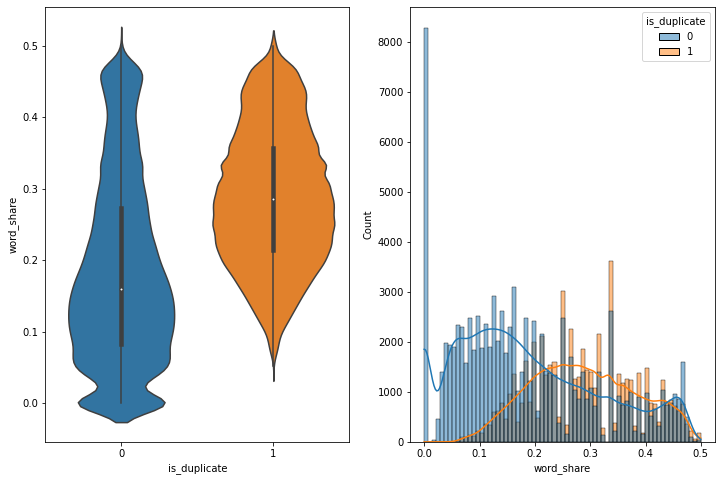

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sn.violinplot(x='is_duplicate', y ='word_share' , data=df[0:])
plt.subplot(1,2,2)
sn.histplot(data=df[0:] ,  x='word_share', hue='is_duplicate', kde=True )
plt.show()

* The distributions of word_share have some overlap on the right-hand side, that means there are lot of questions with high word similarity .
* The avg word_share of qid1 and qid2 is more when they are duplicate .

<h4> 3.3.1.4. Feature Word_Commoon </h4>

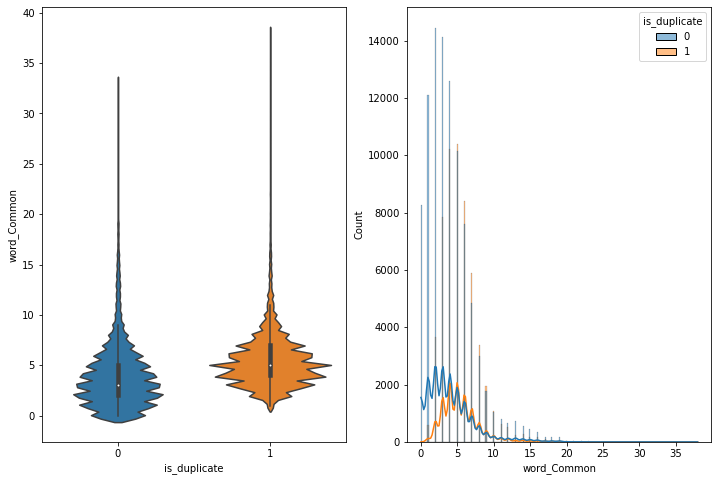

In [29]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sn.violinplot(x='is_duplicate', y ='word_Common' , data=df[0:])
plt.subplot(1,2,2)
sn.histplot(data=df[0:] ,  x='word_Common', hue='is_duplicate', kde=True )
plt.show()

The distribution of word_common Feature in duplicate and non duplicate features is highly overlapping.